In [168]:
%pip install gensim pyLDAvis

Note: you may need to restart the kernel to use updated packages.


In [169]:
import re
import multiprocessing
import warnings

import pandas as pd
import numpy as np

import spacy
from gensim import corpora
from gensim.models import CoherenceModel
from gensim.models.ldamulticore import LdaMulticore

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
from IPython.display import display

warnings.filterwarnings("ignore", category=DeprecationWarning)

In [170]:
nlp = spacy.load("en_core_web_sm", disable=["ner", "parser"])

In [171]:
url = "https://raw.githubusercontent.com/Catrilao/text-mining/refs/heads/main/movie_data.csv"
df = pd.read_csv(url)
df.sample(10)

,review,sentiment
11035,This film is a flagrant rip-off of one of the ...,0
40128,"Somehow, this documentary about Miles manages ...",0
42142,An absolutely atrocious adaptation of the wond...,0
20368,"I enjoy watching people doing breakdance, espe...",1
5329,It must have been excruciating to attend the d...,0
22750,"""Fido"" is to be commended for taking a tired g...",1
5497,"I watch movies for a living, picking out which...",1
44839,i went to see this movie with a bunch of frien...,1
30806,Uneven Bollywood drama. Karisma Kapoor is exce...,1
27050,I feel privileged to have accidentally seen th...,1


## Procesamiento y preparación de datos
Como primera etapa, deberán realizar el procesamiento de los datos. <br>
Deben justificar rigurosamente la elección de cada técnica aplicada,
explicando su pertinencia según las características de cada dataset. <br>
Puede basarse en los resultados de los talleres realizados durante el semestre.


Se ejecutaran las siguientes tareas:
<ol>
<li>Remover etiquetas html</li>
<li>Remover carácteres especiales</li>
<li>Convertir todo a minúscula</li>
<li>Remover stopwords</li>
<li>Lematización</li>
</ol>

### Definición de stopwords

In [ ]:
stop_words = nlp.Defaults.stop_words.copy()

negations_and_connectors = {
    'no', 'not', 'nor', 'never', 'neither', 'but', 'however', 'although', 
    'n\'t', "n't", 'movie', 'film'
}

domain_stopwords = {
    'movie', 'movies', 'film', 'films', 'cinema',
    'watch', 'watched', 'watching', 'see', 'seen',
    'actor', 'actress', 'director', 'star', 'cast',
    'episode', 'serie', 'series', 'season', 'character', 'scene',
    'make', 'made', 'think', 'thought', 'know',
    'time', 'way', 'people', 'thing', 'life', 'story', 'plot'
}

sentiment_stopwords = {
    'good', 'bad', 'great', 'terrible', 'excellent', 'awful', 'best', 'worst', 
    'like', 'love', 'enjoy', 'hate', 'boring', 'amazing', 'beautiful'
}

stop_words |= negations_and_connectors
stop_words |= domain_stopwords
stop_words |= sentiment_stopwords

### Funciones de limpieza

In [173]:
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"<.*?>", " ", text)
    text = re.sub(r"[^a-z0-9'\- ]+", " ", text) 
    text = re.sub(r"\s+", " ", text)
    return text.strip()

def preprocess_batch(texts):
    clean_texts_gen = (clean_text(t) for t in texts)
    processed_docs = []
    
    for doc in nlp.pipe(clean_texts_gen, batch_size=200):
        tokens = []
        for token in doc:
            lemma = token.lemma_.lower()

            lemma = lemma.strip('-')
            
            if lemma in stop_words:
                continue
            
            if len(lemma) < 2 and not lemma.isdigit():
                continue

            if not lemma.isalnum() and '-' not in lemma:
                if lemma not in negations_and_connectors:
                    continue

            tokens.append(lemma)
            
        processed_docs.append(" ".join(tokens))        
    return processed_docs

### Resultado

In [174]:
df["clean"] = preprocess_batch(df["review"])

In [175]:
df[["review", "clean"]].sample(10)

,review,clean
42312,A March 1947 New York Times article described ...,march 1947 new york times article describe cro...
2147,I only voted it 2/10 mainly because Hitchcock ...,vote 2 10 mainly hitchcock agree direct certai...
40112,I watched this movie with some curiosity. I wa...,curiosity want 1 paul muni play chinese 2 luis...
25139,"Curiously, it is Rene Russo's eyes and mouth--...",curiously rene russo eye mouth buddy emerge fo...
3356,Bad. Bad. Bad. Those three lines sum up this c...,line sum crappy little attract idiot child par...
23843,"Hadnt heard a lot about this movie, except it ...",hear lot national award oscar entry marathi ap...
8297,This movie has it all. It is a classic depicti...,classic depiction event surround migration tho...
40875,What a disappointment... admittedly the best o...,disappointment admittedly prequel weak rush en...
17346,"If this is classed as 'real life' of London, t...",class real london producer different planet de...
48618,Brown of Harvard is a hard movie to pin down. ...,brown harvard hard pin expect lot day help rem...


## Clustering

Implemente un modelo de clustering aplicable a los datos de su proyecto. Para esta sección
deberá:
<ol>
    <li>Seleccionar y justificar el tipo de distancia utilizada.</li>
    <li>Elegir un algoritmo de clustring y justificar la elección según las propiedades de los datos.</li>
    <li>Analice y obtenga una conclusión de los resultados obtenidos.</li>
    <li>Grafique los resultados obtenidos.</li>
</ol>

In [176]:
vectorizer = TfidfVectorizer(
    min_df=5,
    max_df=0.95,
    max_features=5000
)

tfidf_matrix = vectorizer.fit_transform(df.clean)

In [177]:
print(f'Matriz creada, {tfidf_matrix.shape} (documentos, palabras únicas)')

Matriz creada, (49969, 5000) (documentos, palabras únicas)


### Elección del algoritmo de clustering

#### Gráfico

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.003s...
[t-SNE] Computed neighbors for 10000 samples in 0.603s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.068106
[t-SNE] KL divergence after 250 iterations with early exaggeration: 93.429420
[t-SNE] KL divergence after 1000 iterations: 3.153917


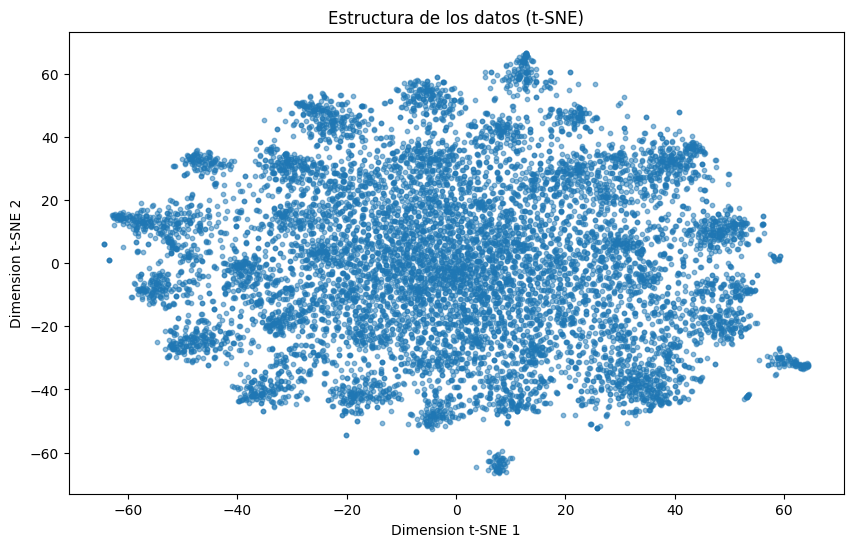

In [178]:
sample_size = 10000
indices = np.random.choice(tfidf_matrix.shape[0], sample_size, replace=False)
matrix_sample = tfidf_matrix[indices] # pyright: ignore[reportIndexIssue]

pca_50 = PCA(n_components=50)
pca_result = pca_50.fit_transform(matrix_sample.toarray())

tsne = TSNE(n_components=2, verbose=1, perplexity=30, random_state=42)
tsne_results = tsne.fit_transform(pca_result)

plt.figure(figsize=(10, 6))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], alpha=0.5, s=10)
plt.title('Estructura de los datos (t-SNE)')
plt.xlabel('Dimension t-SNE 1')
plt.ylabel('Dimension t-SNE 2')
plt.show()

Al encontrar "nubes" decidimos usar k-means

#### Selección de distancia

In [179]:
print(f"Largo de documento más corto: {min(df.clean.apply(len))}")
print(f"Largo de documento más largo: {max(df.clean.apply(len))}")

Largo de documento más corto: 4
Largo de documento más largo: 7529


Como los documentos pueden variar su longitud de gran manera aún si hablan del mismo tema y evocan el mismo sentimiento. <br>

Es por esto que descartamos tanto la distancia Euclidiana como la Manhattan, ya que ambas se ven afectadas por la magnitud del documento. <br>
K-Means usa calcula la distancia Euclideana pero al haber normalizado la matriz de documentos, esta se vuelve matemáticamente equivalente a <br>
la distancia coseno.

Dimensiones de la matriz TF-IDF: (49969, 5000)


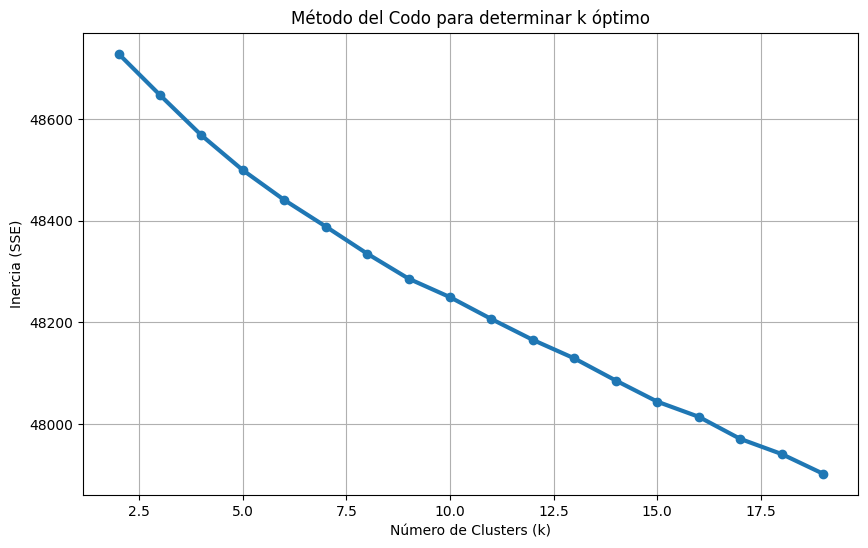

In [180]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

tfidf_vectorizer = TfidfVectorizer(max_features=5000, min_df=5) 
tfidf_matrix = tfidf_vectorizer.fit_transform(df['clean'])

print(f"Dimensiones de la matriz TF-IDF: {tfidf_matrix.shape}")

sse = []
list_k = list(range(2, 20))

for k in list_k:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(tfidf_matrix)
    sse.append(km.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(list_k, sse, '-o', linewidth=3)
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Inercia (SSE)')
plt.title('Método del Codo para determinar k óptimo')
plt.grid(True)
plt.show()

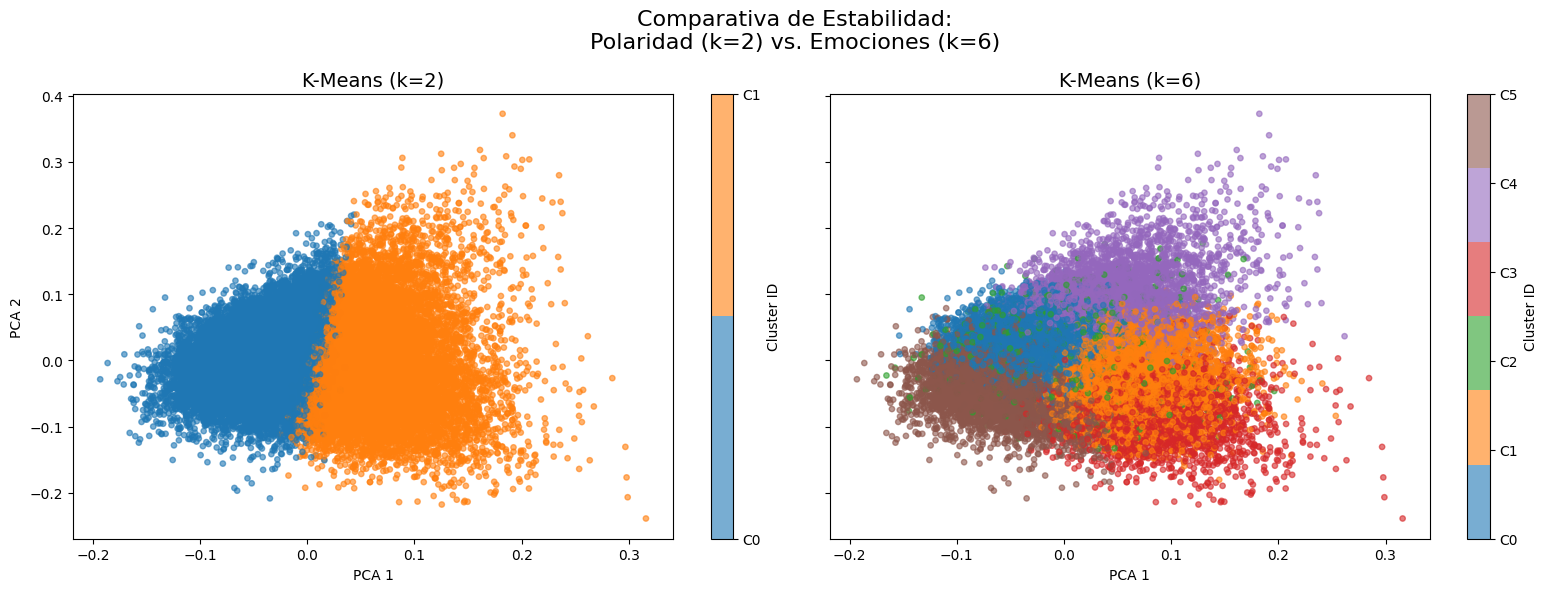

In [181]:
pca = PCA(n_components=2, random_state=42)
coords = pca.fit_transform(tfidf_matrix.toarray()) # pyright: ignore[reportAttributeAccessIssue]

k_values = [2, 6] 
fig, axes = plt.subplots(1, len(k_values), figsize=(16, 6), sharey=True)
modelos_guardados = {}
colors = plt.cm.tab10.colors # pyright: ignore[reportAttributeAccessIssue]

for k, ax in zip(k_values, axes):
    model = KMeans(n_clusters=k, random_state=42, n_init='auto')
    clusters = model.fit_predict(tfidf_matrix)

    cmap_k = ListedColormap(colors[:k])
    
    modelos_guardados[k] = clusters
    df[f'cluster_k{k}'] = clusters
    
    scatter = ax.scatter(
        coords[:, 0],
        coords[:, 1],
        c=clusters,
        cmap=cmap_k,
        s=15,
        alpha=0.6
    )
    
    ax.set_title(f'K-Means (k={k})', fontsize=14)
    ax.set_xlabel('PCA 1')
    if k == k_values[0]:
        ax.set_ylabel('PCA 2')

    cbar = plt.colorbar(scatter, ax=ax)
    cbar.set_label('Cluster ID')
    cbar.set_ticks(np.arange(k)) # pyright: ignore[reportArgumentType]
    cbar.set_ticklabels([f"C{i}" for i in range(k)])
    
plt.suptitle('Comparativa de Estabilidad:\nPolaridad (k=2) vs. Emociones (k=6)', fontsize=16)
plt.tight_layout()
plt.show()

### Análisis Semántico

In [182]:
def mostrar_top_words_comparativo(tfidf_matrix, vectorizer, df_labels, k_list, top_n=10):
    feature_names = vectorizer.get_feature_names_out()
    df_tfidf = pd.DataFrame(tfidf_matrix.toarray(), columns=feature_names)
    
    for k in k_list:
        columna_cluster = f'cluster_k{k}'
        df_tfidf['cluster'] = df_labels[columna_cluster].values
        centroides = df_tfidf.groupby('cluster').mean()
        
        print(f"\n{'='*20} MODELO K={k} {'='*20}")
        for i, row in centroides.iterrows():
            top_words = row.sort_values(ascending=False).head(top_n).index.tolist()
            print(f"[Cluster {i}]: {', '.join(top_words)}")

        df_tfidf = df_tfidf.drop(columns=['cluster'])

mostrar_top_words_comparativo(tfidf_matrix, vectorizer, df, [2, 6])


==================== MODELO K=2 ====================
[Cluster 0]: play, man, year, find, work, performance, come, look, role, end
[Cluster 1]: look, funny, horror, guy, end, want, act, try, laugh, 10

==================== MODELO K=6 ====================
[Cluster 0]: book, play, performance, year, find, music, work, look, come, role
[Cluster 1]: look, end, waste, act, guy, minute, want, acting, action, try
[Cluster 2]: kid, child, disney, old, year, family, adult, little, parent, young
[Cluster 3]: horror, zombie, gore, scary, look, fan, effect, budget, flick, slasher
[Cluster 4]: funny, comedy, laugh, joke, humor, hilarious, find, try, lot, come
[Cluster 5]: man, woman, play, young, find, war, come, family, end, year


IndexError: index 6 is out of bounds for axis 0 with size 6

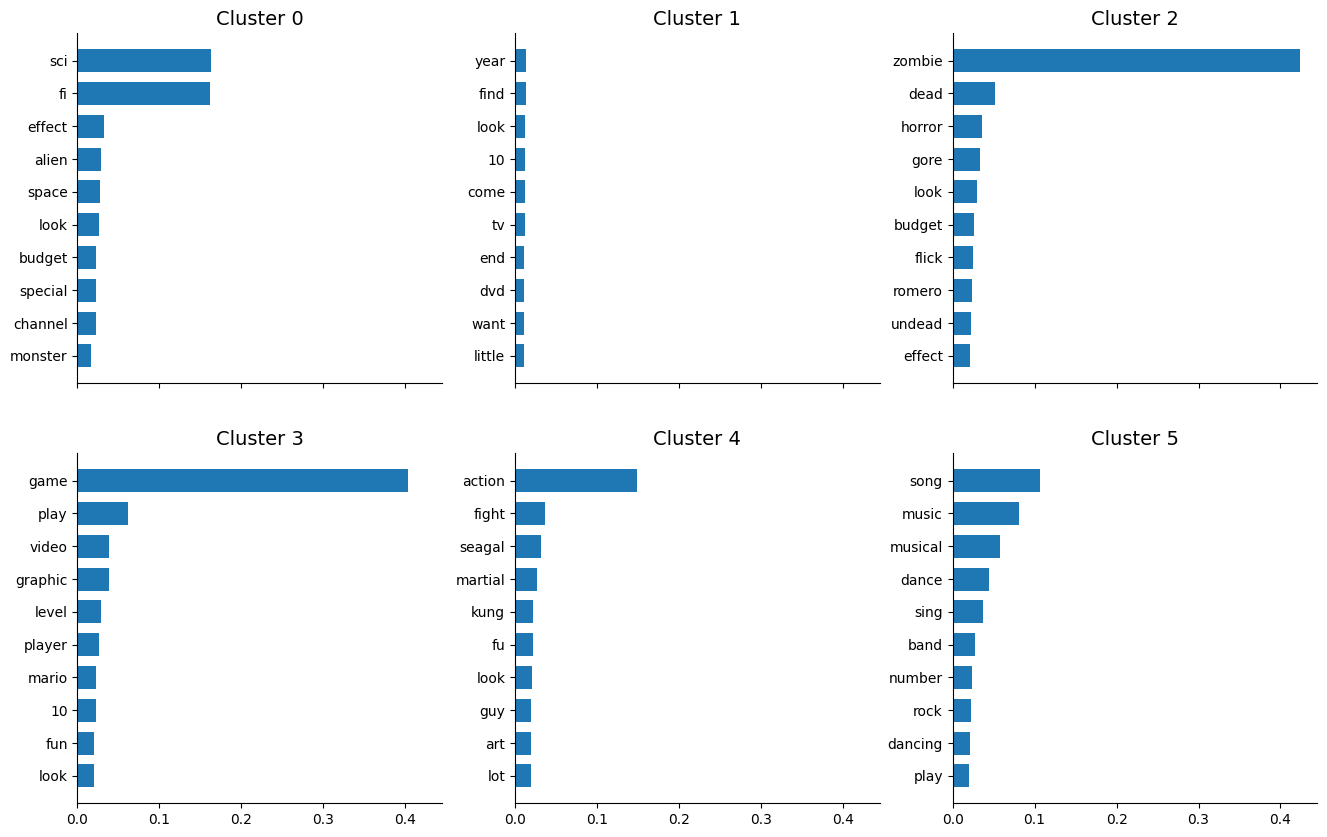

In [ ]:
def plot_top_words(model, feature_names, n_top_words=10, title="Top palabras por Cluster"):
    fig, axes = plt.subplots(2, 3, figsize=(16, 10), sharex=True)
    axes = axes.flatten()
    
    for cluster_idx, topic in enumerate(model.cluster_centers_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[cluster_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f'Cluster {cluster_idx}', fontdict={'fontsize': 14})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=10)
        
        for i in "top right".split():
            ax.spines[i].set_visible(False)

    fig.suptitle(title, fontsize=16)
    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.3, hspace=0.3)
    plt.show()

feature_names = tfidf_vectorizer.get_feature_names_out()
plot_top_words(km, feature_names, n_top_words=10, title="Palabras Clave en Clusters de Reviews (k=6)")

## 3. Modelado de tópicos (Topic Models).
Desarrolle un modelo de tópicos, para lo que debe:
<ol>
    <li>Justificar los parámetros seleccionados (número de tópicos, hiperparámetros específicos, regularización, etc.).</li>
    <li>Explicar la interpretación de los tópicos obtenidos.</li>
    <li>Grafique los resultados obtenidos</li>
</ol>

In [ ]:
data_tokens = [doc.split() for doc in df.clean]
id2word = corpora.Dictionary(data_tokens)
id2word.filter_extremes(no_below=10, no_above=0.5)

corpus = [id2word.doc2bow(text) for text in data_tokens]

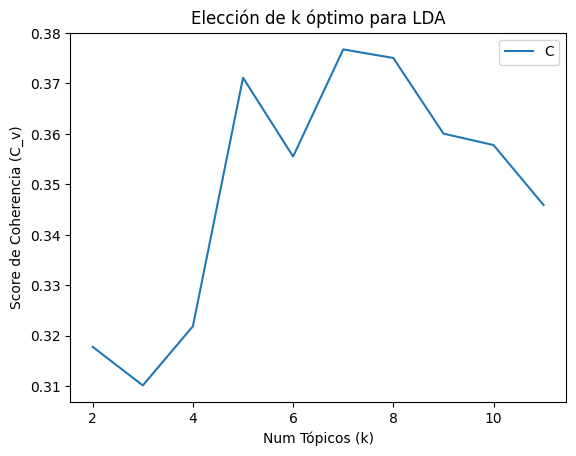

In [ ]:
def compute_coherence_values2(dictionary, corpus, texts, limit, start, step):
    model_list = []
    coherence_values = []

    for num_topics in range(start, limit, step):
        model = LdaMulticore(
            corpus=corpus,
            id2word=dictionary,
            num_topics=num_topics,
            workers=multiprocessing.cpu_count() - 1,
            chunksize=1000,
            passes=10,
            random_state=42
        )
        model_list.append(model)

        coherence_model = CoherenceModel(
            model=model,
            texts=texts,
            dictionary=dictionary,
            coherence='c_v'
        )
        coherence_values.append(coherence_model)

    return model_list, coherence_values

limit=12
start=2
step=1
model_list, coherence_values = compute_coherence_values2(
    dictionary=id2word,
    corpus=corpus,
    texts=data_tokens,
    limit=limit,
    start=start,
    step=step
)
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Tópicos (k)")
plt.ylabel("Score de Coherencia (C_v)")
plt.title("Elección de k óptimo para LDA")
plt.legend(("Coherence_values"), loc='best')
plt.show()

In [ ]:
optimal_k = 7
lda_model_final = LdaMulticore(
                    corpus=corpus,
                    id2word=id2word,
                    num_topics=optimal_k,
                    random_state=42,
                    workers=multiprocessing.cpu_count() - 1,
                    chunksize=2000,
                    passes=10,
                )

pyLDAvis.enable_notebook()
vis_data = gensimvis.prepare(lda_model_final, corpus, id2word)
display(vis_data)

pyLDAvis.save_html(vis_data, 'lda_visualization.html')

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.054167  0.026933       1        1  16.171963
5      0.082874 -0.032033       2        1  15.873807
1     -0.071045  0.056086       3        1  15.447076
0      0.062731  0.039499       4        1  14.630910
6     -0.037044  0.006530       5        1  14.244712
4     -0.066376 -0.011917       6        1  12.202154
2     -0.025306 -0.085098       7        1  11.429378, topic_info=        Term         Freq         Total Category  logprob  loglift
26     funny  8991.000000   8991.000000  Default  30.0000  30.0000
723   horror  7545.000000   7545.000000  Default  29.0000  29.0000
1399     war  5105.000000   5105.000000  Default  28.0000  28.0000
1304  comedy  7255.000000   7255.000000  Default  27.0000  27.0000
790    laugh  6065.000000   6065.000000  Default  26.0000  26.0000
...      ...          ...           ...      ...      ...      ...
389      big  1034.281184   8466.867322   Topic7  -6.1320   0.0665
91      work  1115.269658  13719.150219   Topic7  -6.0567  -0.3407
586    young  1014.075168   8129.703208   Topic7  -6.1518   0.0874
174   little  1051.508259  12410.242874   Topic7  -6.1155  -0.2993
47      tell   943.577064   8207.006221   Topic7  -6.2238   0.0059

[714 rows x 6 columns], token_table=       Topic      Freq    Term
term                          
12597      7  0.984797     007
92         1  0.393505       1
92         2  0.218195       1
92         3  0.042178       1
92         4  0.199344       1
...      ...       ...     ...
817        5  0.006022  zombie
817        6  0.001506  zombie
817        7  0.003011  zombie
11171      2  0.014778   zorro
11171      7  0.975358   zorro

[2490 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 6, 2, 1, 7, 5, 3])

Visualización guardada como 'lda_visualization.html'
